### Author: [Parvaneh Yaghoubi](https://github.com/parvanehyaghoubi)

# Real time signal processing in EEG

## Import libraries

In [1]:
import pandas as pd
from scipy import signal
import numpy as np
import time
import pylab as pl
from IPython import display

## Real time signal processing in EEG

Real-time signal processing in EEG (electroencephalography) is critical for several reasons. First, it provides immediate analysis and interpretation of brain activity, which is important for applications such as neurofeedback, brain-computer interfaces (BCI), and real-time monitoring of neurological conditions.

In addition, real-time processing facilitates adaptive algorithms that can dynamically adapt to changing brain states, increasing the accuracy and effectiveness of interventions. This immediacy also improves the user experience in BCI by reducing latency, resulting in a smoother, more responsive experience.

**Positive**  

* Responsiveness: Real-time processing minimizes latency, making BCIs more effective and user-friendly by providing quick responses to user inputs.  
* Adaptive Algorithms: Algorithms can dynamically adjust to ongoing changes in brain activity, enhancing the accuracy and functionality of BCIs.

**Negative**  

* Signal Noise: EEG signals are often contaminated with noise from various sources (e.g., muscle movements, electrical interference), which can complicate real-time processing and reduce accuracy.  
* Computational Load: Real-time processing requires significant computational resources to filter, analyze, and interpret EEG data promptly.  
* Accuracy: The need for fast processing can sometimes compromise the accuracy of signal interpretation, leading to false positives or negatives.  
* Generalization: Real-time algorithms may not generalize well across different subjects or conditions, necessitating extensive customization and tuning.  

**How it works**

When working in real time, the main difference is the need to create a data buffer. It's crucial to determine the length of data that will be fed into the filter for processing and subsequent visualization. For instance, with a frame rate of 250 FPS (meaning we receive 250 EEG data points from each channel per second), data processing and visualization would occur once per secund. However, for bandpass filters, it is important to supply data with a margin, as the filter needs time for adjusting.

In our example, we demonstrate the ability to set the length of one data packet and how many packets will be fed into the filter.

**Recommendation**

Try adjusting the bandpass filter settings and aim to achieve a faster graph update rate. Currently, the graph updates every sec.


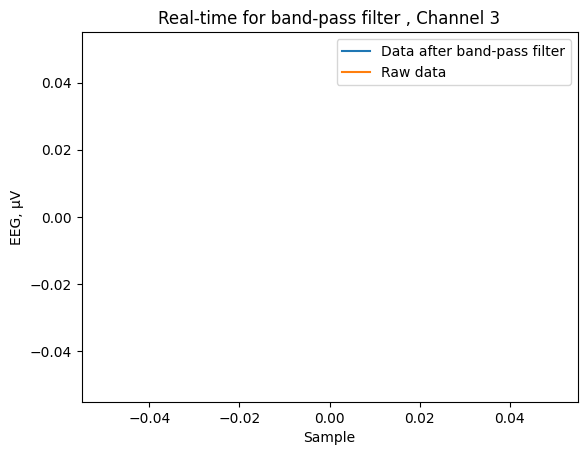

In [ ]:
"""
This script processes real-time EEG data using a Butterworth bandpass filter.
The butter_bandpass function designs the filter by calculating the normalized cutoff frequencies and using the scipy.signal.butter function.
The butter_bandpass_filter function applies this filter to the data.
The main loop reads EEG data from an Excel file in chunks, initially gathering enough data for the filter, then continually adding new data.
Each new dataset is combined with the previous filtered data, processed through the bandpass filter, and plotted in real-time to visualize the filtered and raw EEG signals.
This process repeats indefinitely, simulating a real-time data processing pipeline.
"""


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data = signal.lfilter(b, a, data)
    return data

dataset_y = pd.read_excel("dataset/dataset.xlsx")

channel = 2

dataset_y_row = dataset_y.iloc[channel]
print (dataset_y_row.shape)
dataset_y = dataset_y.transpose()
dataset_y = dataset_y.iloc[0]
just_one_time = 0
data_before = []
data_after = []
fps = 250
cutoff = 1
cutoffs = 10


data_lenght_for_Filter = 4     # how much we read data for filter, all lenght  [_____] + [_____] + [_____]
read_data_lenght_one_time = 1   # for one time how much read  [_____]

start = 0
total_lenght = end = 500


while 1:
        if just_one_time == 0:
            for b in range (0,data_lenght_for_Filter,1):
                for a in range (0,read_data_lenght_one_time,1):
                    data_read = dataset_y[start:end]
                    start = start + 250
                    end = end + 250
                    data_before.append(data_read)

            just_one_time = 1
            data_before = data_before[read_data_lenght_one_time:]

        for c in range (0,read_data_lenght_one_time,1):
            data_read = dataset_y[start:end]
            start = start + 250
            end = end + 250
            data_after.append(data_read)

        data_before_for_sum = data_before
        data_after_for_sum = data_after

        data_before_for_sum = [item for sublist in data_before for item in sublist]
        data_after_for_sum = [item for sublist in data_after for item in sublist]
        dataset =  data_before_for_sum + data_after_for_sum #+ data_after_flip
        dataset = [int(x) for x in dataset]

        dataset_before = data_before + data_after
        data_before = dataset_before[read_data_lenght_one_time:]
        data = butter_bandpass_filter(dataset, cutoff, cutoffs,fps)

        data_after = []
        dataset = []


        pl.clf()
        pl.plot(data[-total_lenght:],label='Data after band-pass filter')
        data_for_graph = np.array(data_read)
        pl.title("Real-time for band-pass filter , Channel " + str(channel + 1))
        pl.ylabel('EEG, µV')
        pl.xlabel('Sample')
        pl.plot(data_for_graph - np.average(data_for_graph), label='Raw data')
        pl.legend()

        display.display(pl.gcf())
        display.clear_output(wait=True)


        time.sleep(1)